In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from scipy.stats import gaussian_kde, norm
from sklearn.mixture import GaussianMixture

from utils_f4f import CustomEarlyStopping, rnn_aa_model,AA_hotencoding ,heatmap, si_format



In [2]:
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.family'] = ['sans-serif']
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['text.usetex'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#### Data_preparetion



In [24]:

df_all = pd.read_csv('../data/1st_780w_packseq_aa.tsv',delimiter='\t')
df_all = df_all.iloc[::5]
df_modeling = df_all.rename(columns={'aa':'AA_seqenece'})
df_modeling['label']=0
df_modeling = df_modeling[['AA_seqenece', 'nor_package', 'label']]
df_missing = df_modeling[np.isinf(df_modeling['nor_package']) ]#
df_modeling = df_modeling[~np.isnan(df_modeling['nor_package']) & ~np.isinf(df_modeling['nor_package'])]
df_modeling.reset_index(drop = True, inplace=True)
AA_col = 'AA_seqenece'
array = 'nor_package'


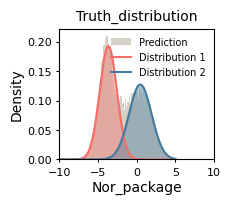

In [25]:
nor_package = df_all[np.isfinite(df_all[array])][array]
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Truth_distribution',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-10,-5, 0, 5,10]); 
ax.set_xlim([-10,10])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
plt.show()

### Prep data
 one-hot encode the `AA_sequence` column and split the data into
training and test sets. The training split will be split



In [26]:
# Train-Test split
train_size = 1400000
validation_size = 60000
train, validate, test = np.split(df_modeling.sample(frac=1),  [train_size, train_size+validation_size])

# Hot Encoding

train_x =  np.asarray([AA_hotencoding(variant) for variant in train[AA_col]])
train_y = train[array]
validate_x = np.asarray([AA_hotencoding(variant) for variant in validate[AA_col]])
validate_y = validate[array]
test_x = np.asarray([AA_hotencoding(variant) for variant in test[AA_col]])
test_y = test[array]
missing_x = np.asarray([AA_hotencoding(variant) for variant in df_missing[AA_col]])


In [27]:
train_x.shape

(9200, 7, 20)

## RNN  model training
Default parameterization:Here the model is applied to aa-nor_package learning process, as details

In [28]:
# Training

# Define model 
model = rnn_aa_model(L1=140, L2=60)

# Training parameters 
batch_size = 500
EpochCount = 120
#EpochCount = 5 #Used for quick excusion of the Notebook; please use a higher number instead to allow proper convergence

# train model 
model.fit(train_x, train_y, batch_size=batch_size, epochs=EpochCount, 
          validation_data=(validate_x, validate_y),verbose=2,
              callbacks=[CustomEarlyStopping(ratio=0.90, patience=20, restore_best_weights = True)])

# Save model
ModelFileName = 'pretrain/model_1st_rnn_aa_nor_package'
model.save(ModelFileName+'.h5')

Epoch 1/120
19/19 - 4s - loss: 8.2626 - mae: 2.4506 - val_loss: 6.7074 - val_mae: 2.2454 - 4s/epoch - 184ms/step
Epoch 2/120
19/19 - 1s - loss: 5.9289 - mae: 2.0971 - val_loss: 5.2920 - val_mae: 1.9833 - 678ms/epoch - 36ms/step
Epoch 3/120
19/19 - 1s - loss: 5.1107 - mae: 1.9373 - val_loss: 4.6543 - val_mae: 1.7931 - 618ms/epoch - 33ms/step
Epoch 4/120
19/19 - 1s - loss: 4.5119 - mae: 1.7687 - val_loss: 4.3024 - val_mae: 1.7094 - 607ms/epoch - 32ms/step
Epoch 5/120
19/19 - 1s - loss: 4.2568 - mae: 1.7015 - val_loss: 4.0864 - val_mae: 1.6437 - 625ms/epoch - 33ms/step
Epoch 6/120
19/19 - 1s - loss: 4.0472 - mae: 1.6514 - val_loss: 3.8965 - val_mae: 1.6014 - 620ms/epoch - 33ms/step
Epoch 7/120
19/19 - 1s - loss: 3.8481 - mae: 1.5978 - val_loss: 3.8118 - val_mae: 1.5849 - 621ms/epoch - 33ms/step
Epoch 8/120
19/19 - 1s - loss: 3.7493 - mae: 1.5626 - val_loss: 3.6891 - val_mae: 1.5396 - 621ms/epoch - 33ms/step
Epoch 9/120
19/19 - 1s - loss: 3.6522 - mae: 1.5303 - val_loss: 3.6836 - val_mae: 

d:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Model validation
· `Train-data validation` 



In [45]:

# Predict for train variants
y = model.predict(train_x)
x = np.array(train_y)
y = np.reshape(y, (1,y.shape[0]))[0]
preds_df = pd.DataFrame(columns=['y_pred','y_true'])
preds_df['y_pred'] = pd.DataFrame(y)
preds_df['y_true']  = pd.DataFrame(x)
preds_df 


 37/288 [==>...........................] - ETA: 0s

288/288 [==============================] - 1s 3ms/step


,y_pred,y_true
0,-3.955602,-3.510700
1,-0.491101,-2.378000
2,-1.076841,-0.579768
3,0.225890,0.311298
4,0.449172,2.664020
...,...,...
9195,-1.673849,-4.044850
9196,-1.195900,0.567638
9197,-3.011897,-3.759090
9198,-3.907591,-4.366770


In [44]:
x = preds_df['y_pred']  
y = preds_df['y_true']   
preds_df['y_pred'][:1000].corr(preds_df['y_true'][:1000])
remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=2000, random_state=1), 
    y_both.sample(n=2000, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))

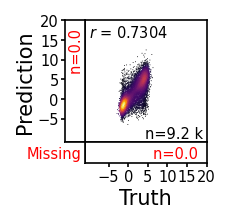

In [34]:
fig = plt.figure(figsize=(1.4,1.3), dpi=150)
gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/rnn/1st_results/nor_package/1st_aa_nor_package_prediction_correlation_train.pdf',dpi=300,bbox_inches='tight')

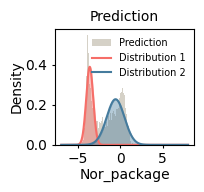

In [36]:
data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # 将数据转换成列向量的形式

# 使用GaussianMixture拟合数据
n_components = 2 # 设置混合模型的分量个数
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# 获取每个分量的均值和协方差矩阵
means = gmm.means_
covariances = gmm.covariances_

# 生成拟合后的分布
x = np.linspace(-7, 8, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(1.8,1.5),dpi=100)
# 绘制原始数据和拟合后的分布
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')
#plt.plot(x, y, '-r', label='GMM fit')


# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)

# ax.spines['top'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5, ]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
fig.savefig('../results/rnn/1st_results/nor_package/1st_aa_nor_package_prediction_distribution_train.pdf',dpi=300,bbox_inches='tight')

· `Test-data validation` 

In [37]:

# Predict for test variants
y = model.predict(test_x)
x = np.array(test_y)
y = np.reshape(y, (1,y.shape[0]))[0]
preds_df = pd.DataFrame(columns=['y_pred','y_true'])
preds_df['y_pred'] = pd.DataFrame(y)
preds_df['y_true']  = pd.DataFrame(x)
preds_df 


186/186 [==============================] - 0s 2ms/step


,y_pred,y_true
0,-4.015704,-3.65218
1,-0.227657,-1.86685
2,-3.742590,-3.93156
3,-0.873402,2.40844
4,-0.077202,-1.34405
...,...,...
5918,0.947092,1.27066
5919,-3.823211,-4.75909
5920,-2.555281,-1.30822
5921,-4.167810,-3.99613


d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


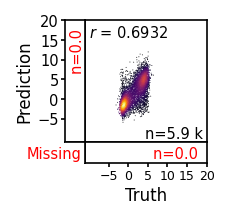

In [42]:
x = preds_df['y_pred']  
y = preds_df['y_true']   
preds_df['y_pred'][:1000].corr(preds_df['y_true'][:1000])
remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=2000, random_state=1), 
    y_both.sample(n=2000, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))

fig = plt.figure(figsize=(1.4,1.3), dpi=150)
gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/rnn/1st_results/nor_package/1st_aa_nor_package_prediction_correlation_test.pdf',dpi=300,bbox_inches='tight')

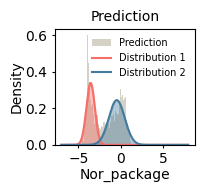

In [40]:
data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # 将数据转换成列向量的形式

# 使用GaussianMixture拟合数据
n_components = 2 # 设置混合模型的分量个数
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# 获取每个分量的均值和协方差矩阵
means = gmm.means_
covariances = gmm.covariances_

# 生成拟合后的分布
x = np.linspace(-7, 8, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(1.8,1.5),dpi=100)
# 绘制原始数据和拟合后的分布
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')
#plt.plot(x, y, '-r', label='GMM fit')


# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)

# ax.spines['top'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5, ]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
fig.savefig('../results/rnn/1st_results/nor_package/1st_aa_nor_package_prediction_distribution_test.pdf',dpi=300,bbox_inches='tight')